In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def read_and_normalize_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = np.float32(image) / 255.0
    return image


In [2]:
def compute_gradients(image):
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=1)
    magnitude, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    return magnitude, angle


In [3]:
def compute_histogram_of_gradients(magnitude, angle, cell_size=8, bin_size=9):
    height, width = magnitude.shape
    angle = angle % 180  # Considerar ângulos de 0 a 180 graus
    num_cells_x = width // cell_size
    num_cells_y = height // cell_size
    hist = np.zeros((num_cells_y, num_cells_x, bin_size))

    for i in range(num_cells_y):
        for j in range(num_cells_x):
            cell_magnitude = magnitude[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]
            cell_angle = angle[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]
            for k in range(cell_size):
                for l in range(cell_size):
                    bin_idx = int(cell_angle[k, l] / (180 / bin_size))
                    hist[i, j, bin_idx] += cell_magnitude[k, l]
    return hist


In [4]:
def normalize_blocks(hist, block_size=2):
    num_blocks_y, num_blocks_x, bin_size = hist.shape[0] - 1, hist.shape[1] - 1, hist.shape[2]
    normalized_hist = np.zeros((num_blocks_y, num_blocks_x, block_size * block_size * bin_size))

    for y in range(num_blocks_y):
        for x in range(num_blocks_x):
            block = hist[y:y + block_size, x:x + block_size].ravel()
            block_norm = np.sqrt(np.sum(block ** 2) + 1e-5)
            normalized_hist[y, x] = block / block_norm
    return normalized_hist.ravel()


In [5]:
def extract_hog_features(image_path, cell_size=8, block_size=2, bin_size=9):
    image = read_and_normalize_image(image_path)
    magnitude, angle = compute_gradients(image)
    hist = compute_histogram_of_gradients(magnitude, angle, cell_size, bin_size)
    hog_features = normalize_blocks(hist, block_size)
    return hog_features


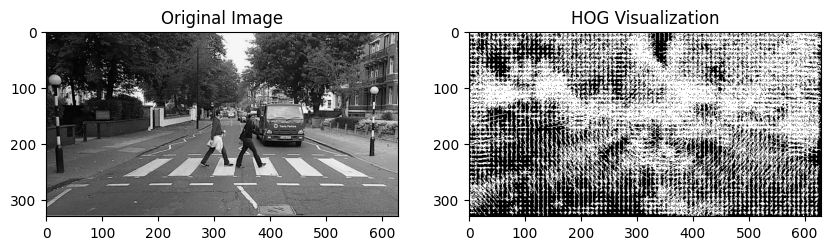

In [17]:
def visualize_hog(image_path, cell_size=8, bin_size=9):
    image = read_and_normalize_image(image_path)
    magnitude, angle = compute_gradients(image)
    hist, angle = compute_histogram_of_gradients(magnitude, angle, cell_size, bin_size), angle

    h, w = image.shape
    num_cells_x = w // cell_size
    num_cells_y = h // cell_size
    bin_width = 180 / bin_size

    hog_image = np.zeros((h, w), dtype=np.float32)
    for i in range(num_cells_y):
        for j in range(num_cells_x):
            cell_hist = hist[i, j]
            for bin_idx in range(bin_size):
                theta = bin_width * bin_idx + bin_width / 2
                magnitude = cell_hist[bin_idx]
                x_center = j * cell_size + cell_size // 2
                y_center = i * cell_size + cell_size // 2
                length = magnitude * cell_size / 2
                x1 = x_center - length * np.cos(np.deg2rad(theta))
                y1 = y_center - length * np.sin(np.deg2rad(theta))
                x2 = x_center + length * np.cos(np.deg2rad(theta))
                y2 = y_center + length * np.sin(np.deg2rad(theta))
                cv2.line(hog_image, (int(x1), int(y1)), (int(x2), int(y2)), 1, 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("HOG Visualization")
    plt.imshow(hog_image, cmap='gray')
    plt.show()

# Path to the image
image_path = 'zebra_crossing_630px.jpg'
visualize_hog(image_path)

In [11]:
image_path = 'zebra_crossing_630px.jpg'